Trial 5 Complete [00h 01m 28s]
val_accuracy: 0.823823094367981

Best val_accuracy So Far: 0.823823094367981
Total elapsed time: 00h 06m 25s


2025-06-01 15:44:01.167137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8212 - loss: 0.5375
Validation loss: 0.5350738167762756
Validation accuracy: 0.823823094367981
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


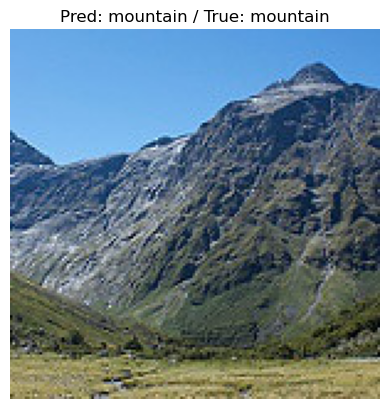

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


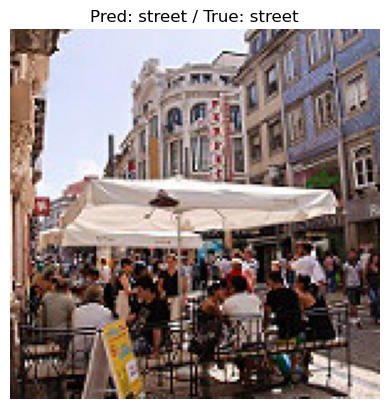

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


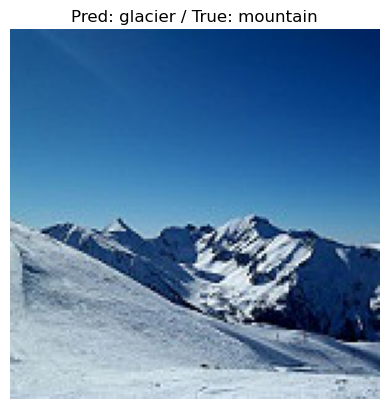

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


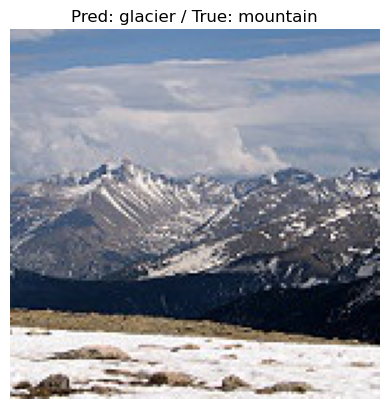

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


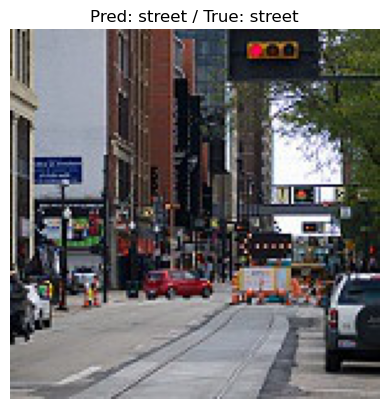

In [7]:
from pathlib import Path
import numpy as np
import os
import json
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import RandomSearch

# Paths
data_dir = Path("/Users/eric/Documents/Masters Degree/M9.-Deep learning aplicada, NLP y visión artificial/7.-Evaluacion final M9/Caso Practico 1/data/seg_train")
test_dir = Path("/Users/eric/Documents/Masters Degree/M9.-Deep learning aplicada, NLP y visión artificial/7.-Evaluacion final M9/Caso Practico 1/data/seg_test/")
model_path = Path("/Users/eric/Documents/Masters Degree/M9.-Deep learning aplicada, NLP y visión artificial/7.-Evaluacion final M9/Caso Practico 1/models/best_model_hptuning.h5")
history_path = Path("/Users/eric/Documents/Masters Degree/M9.-Deep learning aplicada, NLP y visión artificial/7.-Evaluacion final M9/Caso Practico 1/models/hptuning_history.json")

# Image generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size = (150, 150),
    batch_size = 16,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,  # 1 image per batch
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size = (150, 150),
    batch_size = 16,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True
)

#Class
class_labels = list(test_generator.class_indices.keys())

# Model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape = (150, 150, 3)))

    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(Conv2D(filters = hp.Choice(f'filters_{i}', [32, 64]), kernel_size=3, activation='relu'))
        model.add(MaxPooling2D(pool_size = 2))

    model.add(Flatten())
    model.add(Dense(units = hp.Int('units_dense', 32, 128, step = 32), activation = 'relu'))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step = 0.1)))
    model.add(Dense(6, activation = 'softmax'))

    model.compile(
        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Tuner
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 5,
    executions_per_trial = 1,
    directory = 'kt_dir',
    project_name = 'hptuning'
)

tuner.search(train_generator,
             validation_data = val_generator,
             epochs = 5,
             callbacks = [EarlyStopping(patience = 3)])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save(model_path)

# Save history 
#best_history = tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_history()
best_history = {}

with open(history_path, 'w') as f:
    json.dump(best_history, f)

# Evaluate best model
results = best_model.evaluate(val_generator)
print("Validation loss:", results[0])
print("Validation accuracy:", results[1])

# Showing 5 images with prediction
for i in range(5):
    image, label = next(test_generator)
    pred = best_model.predict(image)
    pred_label = np.argmax(pred)
    true_label = np.argmax(label)

    plt.imshow(image[0])
    plt.title(f"Pred: {class_labels[pred_label]} / True: {class_labels[true_label]}")
    plt.axis('off')
    plt.show()
